In [1]:
#references : https://www.youtube.com/watch?v=-QUyD0YFYb0&ab_channel=HDMVision
# https://www.youtube.com/watch?v=kMJDsh0TCik&ab_channel=ManusiaSetengahChiKuadrat

In [2]:
import pandas as pd
import numpy as np
import re
import string

# Read Data

In [3]:
review_nlp = pd.read_csv('./review tokped mentah.csv')
review_nlp.head()

,content,score
0,keren,5
1,sukses untuk GOTO,5
2,Kenapa tidak bisa top up,1
3,"Saya beli hp di sini baru ini begini, reseller...",1
4,good job,5


In [4]:
review_nlp['score'].value_counts()

5    122
1     45
4     13
2     10
3     10
Name: score, dtype: int64

# Labeling

In [5]:
label = []

for index, row in review_nlp.iterrows():
    if row['score'] >=4 :
        label.append(1)
    else : 
        label.append(0)
        
review_nlp['label'] = label
review_nlp = review_nlp.drop(columns=['score'])

review_nlp.head()

,content,label
0,keren,1
1,sukses untuk GOTO,1
2,Kenapa tidak bisa top up,0
3,"Saya beli hp di sini baru ini begini, reseller...",0
4,good job,1


In [6]:
review_nlp['label'].value_counts()

1    135
0     65
Name: label, dtype: int64

# mengatasi data tidak imbang

In [7]:
#oversampling
s1 = review_nlp[review_nlp['label']==1].sample(130, replace=True)
s2 = review_nlp[review_nlp['label']==0].sample(130, replace=True)
review_nlp = pd.concat([s1,s2])
print(review_nlp.shape)
print(review_nlp['label'].value_counts(normalize=True))

(260, 2)
1    0.5
0    0.5
Name: label, dtype: float64


# visualisasi text

In [8]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

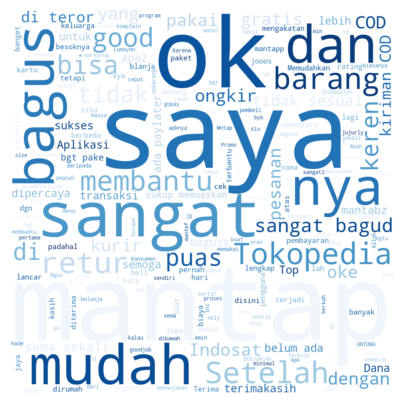

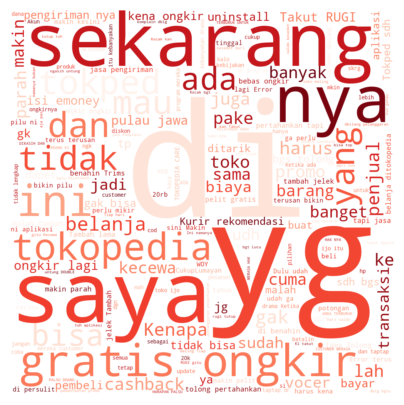

In [9]:
content_1 = review_nlp[review_nlp['label']==1]
content_1 = ' '.join(word for word in content_1['content'])
wcloud = WordCloud(colormap='Blues', width=1000, height=1000, mode= 'RGBA', background_color='white').generate(content_1)
plt.figure(figsize=(5, 5))
plt.imshow(wcloud, interpolation='bilinear')
plt.axis('off')
plt.margins(x=0, y=0)
plt.show()

content_0 = review_nlp[review_nlp['label']==0]
content_0 = ' '.join(word for word in content_0['content'])
wcloud = WordCloud(colormap='Reds', width=1000, height=1000, mode= 'RGBA', background_color='white').generate(content_0)
plt.figure(figsize=(5, 5))
plt.imshow(wcloud, interpolation='bilinear')
plt.axis('off')
plt.margins(x=0, y=0)
plt.show()

# Text Cleansing

In [10]:
def remove_unused(text):
    text = re.sub('[0-9]+', '', text)
    text = re.sub(r'\$\w*', '', text)
    text = re.sub(r'@[\w]*', '', text)
    text = re.sub(r'https?://\S+', '', text)
    text = re.sub(r'#', '', text)
    text = re.sub(r'RT[\s]+', '', text)
    text = text.replace('\n', ' ')
    text = text.encode('ascii', 'ignore').decode('utf-8')
    text = re.sub(r'[^\x00-\x7f]', r'', text)
    text = re.sub(r'[^\w]', ' ', text)
    space = ['    ', '   ', '  ']
    for i in space:
        text = text.replace(i, ' ')
    text = text.lower().strip()
#     text = text.translate(str.maketrans('', '', string.punctuation))
    return text

In [11]:
review_nlp['clean text'] = review_nlp['content'].apply(lambda x: remove_unused(x))
review_nlp = review_nlp[['clean text', 'label']]

In [12]:
review_nlp

,clean text,label
197,belum ada paylater nya,1
126,cepat tidak berat di aplikasi,1
135,skuy,1
197,belum ada paylater nya,1
46,ok,1
...,...,...
63,tokopedia care adalah pelayanan terburukk sepa...,0
48,gratis ongkir nya kurang banyak,0
147,tokopedia gimana sih batalin pesananseenaknya ...,0
55,mgak bisa belanja,0


In [13]:
#import stemmer
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.stem import PorterStemmer
stemmer_e = PorterStemmer()
stemmer = StemmerFactory().create_stemmer()

In [14]:
#import stopword
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from nltk.corpus import stopwords
stopworder = set(stopwords.words('indonesian', 'english'))
stopword = StopWordRemoverFactory().create_stop_word_remover()

In [15]:
def cleansing(data):
    stemm_id = stemmer.stem(data) #stemmer indo
    stemm_en = stemmer_e.stem(stemm_id) #stemmer inggris
    stopwording_id = stopword.remove(stemm_en)
    stopwording_en = [word for word in [stopwording_id] if word not in stopworder]
    text = ' '.join(word for word in stopwording_en)
    return text

In [16]:
#contoh
tes ='jika novel berteriak minta keadilan bagaimana'
cleaned = cleansing(tes)
print(cleaned)

novel teriak adil


In [17]:
data_clean = review_nlp['clean text'].apply(cleansing)

In [18]:
data_clean

197                                             paylater
126                                 cepat berat aplikasi
135                                                 skuy
197                                             paylater
46                                                    ok
                             ...                        
63     tokopedia care layan terburukk seller tuduh yg...
48                                         gratis ongkir
147    tokopedia gimana sih batalin pesananseenaknya ...
55                                          mgak belanja
24     tokopedia pelit gratis ongkirnya tinggal lampu...
Name: clean text, Length: 260, dtype: object

In [19]:
review_nlp['text'] = data_clean
data_nlp = review_nlp[['text', 'label']]

In [20]:
data_nlp.head()

,text,label
197,paylater,1
126,cepat berat aplikasi,1
135,skuy,1
197,paylater,1
46,ok,1


# Feature Enginering TF-IDF

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [22]:
vectorizer_tfidf = TfidfVectorizer()

In [23]:
chat = ['halo apa kabar', 
        'selamat bulan puasa',
        'lagi dimana',
        'how dinner eat'
       ]
chet = ['haha apa kabar', 
        'selam bulan puasa',
        'lagi mana',
        'horse eat'
       ]

In [24]:
vectorized_tfidf = vectorizer_tfidf.fit_transform(chat)

In [25]:
vectorized_tfidf.shape

(4, 11)

In [26]:
#contoh feature
print(vectorized_tfidf.todense())

[[0.57735027 0.         0.         0.         0.         0.57735027
  0.         0.57735027 0.         0.         0.        ]
 [0.         0.57735027 0.         0.         0.         0.
  0.         0.         0.         0.57735027 0.57735027]
 [0.         0.         0.70710678 0.         0.         0.
  0.         0.         0.70710678 0.         0.        ]
 [0.         0.         0.         0.57735027 0.57735027 0.
  0.57735027 0.         0.         0.         0.        ]]


In [27]:
vectorizer_tfidf.get_feature_names()

C:\Users\asus\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['apa',
 'bulan',
 'dimana',
 'dinner',
 'eat',
 'halo',
 'how',
 'kabar',
 'lagi',
 'puasa',
 'selamat']

In [28]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(review_nlp['text'], review_nlp['label'], test_size=0.1,
                                                  stratify = review_nlp['label'], random_state=30)

# merubah text menjadi numeric

In [29]:
X_train = vectorizer_tfidf.fit_transform(X_train) 
X_test = vectorizer_tfidf.transform(X_test)

print(X_train.shape)
print(X_test.shape)

(234, 524)
(26, 524)


# Modeling

In [56]:
from sklearn import svm
svm_clf = svm.SVC(kernel='linear')

In [57]:
model_svm = svm_clf.fit(X_train, y_train)

In [58]:
pred = model_svm.predict(X_test)

In [59]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [60]:
accuracy = accuracy_score(y_test, pred)
print(f'accuracy : {accuracy}')

accuracy : 0.9615384615384616


In [61]:
clf_r = classification_report(y_test, pred)
print(clf_r)

              precision    recall  f1-score   support

           0       0.93      1.00      0.96        13
           1       1.00      0.92      0.96        13

    accuracy                           0.96        26
   macro avg       0.96      0.96      0.96        26
weighted avg       0.96      0.96      0.96        26



C:\Users\asus\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


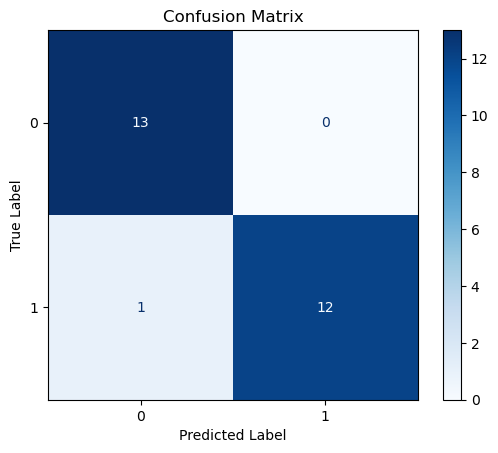

In [62]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
 
color = 'black'
matrix = plot_confusion_matrix(svm_clf, X_test, y_test, cmap=plt.cm.Blues)
matrix.ax_.set_title('Confusion Matrix', color=color)
plt.xlabel('Predicted Label', color=color)
plt.ylabel('True Label', color=color)
plt.gcf().axes[0].tick_params(colors=color)
plt.gcf().axes[1].tick_params(colors=color)
plt.show()

In [63]:
import pickle

In [64]:
pickle.dump(model_svm,open('model_svm_tfidf.pkl', 'wb'))

# Prediksi

In [65]:
label = {1 : 'good', 0 : 'bad'}
print(label)

{1: 'good', 0: 'bad'}


In [66]:
textb = 'sangat bagus, aplikasi mudah membantu, suka berguna'
textj = 'susah jelek tidak berguna buruk kecewa'

# Cleansing

In [67]:
text_clean = remove_unused(textj)
print(text_clean)
text_clean = cleansing(text_clean)
print(text_clean)

susah jelek tidak berguna buruk kecewa
susah jelek buruk kecewa


# to numeric

In [68]:
pred_text = vectorizer_tfidf.transform([text_clean])
print(pred_text.shape)
print(pred_text.todense())

(1, 524)
[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.51346717 0.         0.         0.
  0.         0.         0.     

In [69]:
prediksi = svm_clf.predict(pred_text)
i = np.max(prediksi)
lab = label[i]
hasil = (f'merupakan text : {lab}')
print(hasil)

merupakan text : bad


In [70]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()

In [71]:
X_traind = X_train.toarray()
X_testd = X_test.toarray()

print(X_traind.shape)
print(X_testd.shape)

(234, 524)
(26, 524)


In [72]:
gnb.fit(X_traind, y_train)
predgnb = gnb.predict(X_testd)

In [73]:
accuracy = accuracy_score(y_test, predgnb)
print(f'accuracy : {accuracy}')

accuracy : 0.9615384615384616


In [74]:
clf_r = classification_report(y_test, predgnb)
print(clf_r)

              precision    recall  f1-score   support

           0       0.93      1.00      0.96        13
           1       1.00      0.92      0.96        13

    accuracy                           0.96        26
   macro avg       0.96      0.96      0.96        26
weighted avg       0.96      0.96      0.96        26



C:\Users\asus\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


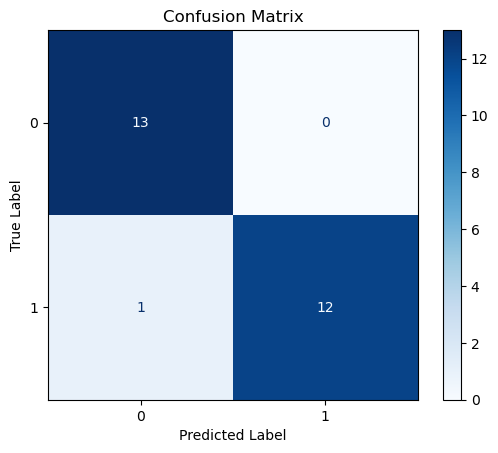

In [75]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
 
color = 'black'
matrix = plot_confusion_matrix(gnb, X_testd, y_test, cmap=plt.cm.Blues)
matrix.ax_.set_title('Confusion Matrix', color=color)
plt.xlabel('Predicted Label', color=color)
plt.ylabel('True Label', color=color)
plt.gcf().axes[0].tick_params(colors=color)
plt.gcf().axes[1].tick_params(colors=color)
plt.show()

In [76]:
prediksi = gnb.predict(pred_text.toarray())
i = np.max(prediksi)
lab = label[i]
hasil = (f'merupakan text : {lab}')
print(hasil)

merupakan text : bad
